In [1]:
import wandb
from tqdm.auto import tqdm
import pandas as pd


def get_summary_metrics(sweep_id, filter_func=None):
  api = wandb.Api(timeout=60)
  sweep = api.sweep(sweep_id)

  data = []
  for run in tqdm(sweep.runs, desc='Runs', leave=False):
    if callable(filter_func) and not filter_func(run):
      continue
    
    run_summary = dict(run_id=run.id, **run.config, **run.summary)
    scan_keys = [k for k in run_summary.keys() if k.endswith(('epoch', 'acc', 'nll', 'avg_nll'))]
    for row in run.scan_history(keys=scan_keys):
      if run_summary['val/best_epoch'] == row['sgd/val/epoch']:
        run_summary = dict(**run_summary, **row)
        break

    data.append(run_summary)

  return sweep, pd.DataFrame(data)

In [2]:
_, metrics = get_summary_metrics('deeplearn/fspace-inference/yb863d1n')

Runs:   0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
metrics[metrics.reg_scale == 0.][['augment', 's/test/acc']]

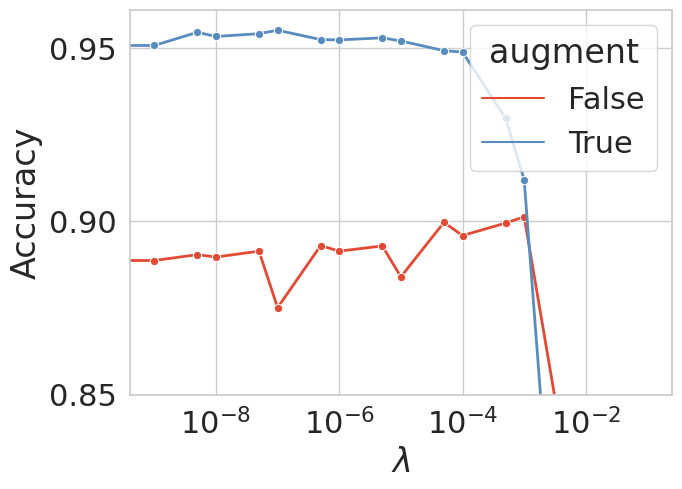

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style='whitegrid', font_scale=2.)

fig, ax = plt.subplots(figsize=(7,5))

sns.lineplot(data=metrics, ax=ax, x='reg_scale', y='s/test/acc', hue='augment', errorbar='sd',
             linewidth=2, marker='o',
             palette=[sns.color_palette("RdYlBu")[0], sns.color_palette("RdYlBu")[-1]])

ax.set_yticks(np.arange(0.85, 0.96, 0.05))
ax.set(xlabel=r'$\lambda$', ylabel='Accuracy', xscale='log', ylim=(.85, .96 + 1e-3));

In [ ]:
metrics.loc[metrics.groupby('augment')['s/test/acc'].idxmax()][['run_id', 'augment', 'reg_scale', 's/test/acc', 's/test/sel_acc', 's/test/avg_nll', 's/test/ece']]